<a href="https://colab.research.google.com/github/leesurkis/Sentinel/blob/master/1_FakeNewsClassifier_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sentinel Take Home - Fake News Classifier 

## 1. **EDA**

In [ ]:
#Importing all the libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from wordcloud import WordCloud
import os
import math

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# read in train data 

fake = pd.read_json('fake_train.json')
real = pd.read_json('real_train.json')

In [ ]:
print(fake.shape) # 300 obeservations
fake.sample(5)

(800, 3)


,url,title,text
129,https://www.saadaonline.net/world/2297768/%D9%...,Corona imposes a new blockade on Iran,Tell me - the increase in cases of coronavirus...
220,https://cz.sputniknews.com/nazory/202003231170...,Coronavirus: The West is at war! Thank God! Op...,The American scientist John Calhoun performed ...
445,http://podneprovie-info.com/2020/02/18/kirill-...,Kirill Vinogradov: Opposition spreads coronavi...,Kirill Vinogradov: Opposition spreads coronavi...
674,https://utro.ru/life/2020/03/06/1437711.shtml,"In Ukraine, developed a remedy for coronavirus",Recipes\n- Diet Cake: Sugar-Free Dessert Recip...
760,http://geworld.ge/ge/%E1%83%99%E1%83%9D%E1%83%...,Coronavirus changes the world order,"Coronavirus, which has spread around the world..."


In [ ]:
print(real.shape) # 300 oberservations (equal to fake)
real.sample(5)

(800, 3)


,url,title,text
55,https://www.thetimes.co.uk/edition/news/retail...,Stores fear empty shelves as coronavirus hits ...,Stores fear empty shelves as coronavirus hits ...
799,https://time.com/magazine/us/5822291/april-27t...,"April 27th , 2020 | Vol . 1 , No . 1 | Asia , ...",Felsenthal is the editor in chief and CEO of T...
393,https://www.theatlantic.com/ideas/archive/2020...,Dont Even Think About Leaving New York City,There are already pockets of disease on Long I...
297,https://www.bbc.com/news/world-europe-52058742,Coronavirus : Can EU get a grip on crisis ?,"Coronavirus: Can EU get a grip on crisis?\n""Th..."
211,https://www.wsj.com/articles/getting-more-doct...,Getting More Doctors Working Where Needed,- Opinion\n- Letters\nGetting More Doctors Wor...


The tables for real and fake have similar set ups, so we are able to compare them directly. Now we will take a closer look at the content by expanding column and row width to look at a sample row.

In [ ]:
def print_full(x):
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

In [ ]:
print_full(real.sample())

                                                                                       url  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
print_full(fake.sample())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               url  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

To take a closer look at the content, we will create wordclouds for each dataset.

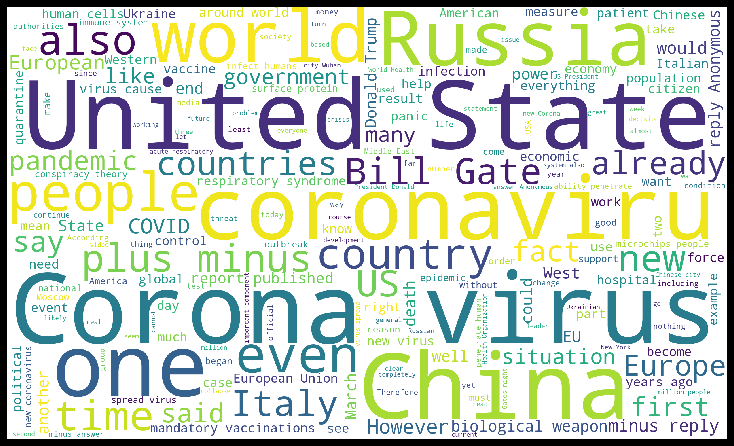

In [ ]:
# wordcloud for fake data 
txt = fake.text.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1500, background_color='white', 
                     stopwords = set(nltk.corpus.stopwords.words("english"))).generate(txt)
fig = plt.figure(figsize=(10, 15), facecolor='k', edgecolor=None)
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del txt

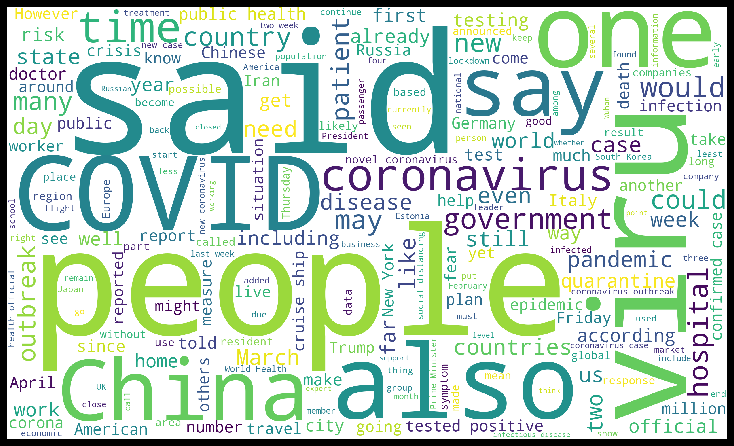

In [ ]:
# wordcloud for real data 
txt = real.text.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1500, background_color='white', 
                     stopwords = set(nltk.corpus.stopwords.words("english"))).generate(txt)
fig = plt.figure(figsize=(10, 15), facecolor='k', edgecolor=None)
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del txt

Initial observations:
* Coronavirus seems to be the main (if not, only) topic in these articles. This may mean that our classifier will be less effective in other news topics.
* 'real' dataset uses softer language, e.g. 'may', 'could', 'would', whereas 'fake' dataset uses stronger language e.g. 'fact', 'first', 'power'
* there are multiple different names for coronavirus, which may interfer with our results. We could replace all with one version of the word but we need to consider that more legitimately technical articles may be more likely to use a specific spelling (e.g. referring to the medical abbreviation COVID which could be a factor)

In [ ]:
# counting number of words in each article per dataset 
fake['words_count'] = fake['text'].str.split().str.len()
real['words_count'] = real['text'].str.split().str.len()

In [ ]:
fake.sample()

,url,title,text,words_count
595,https://www.alarab.com/Article/941981,"Amir Khan: Corona Virus Linked to ""5G"" Network...","The British boxer, Amir Khan, believes that th...",99


In [ ]:
fake.words_count.describe()

count      800.000000
mean       538.756250
std       1057.623072
min          6.000000
25%        188.750000
50%        260.000000
75%        550.250000
max      23930.000000
Name: words_count, dtype: float64

In [ ]:
real.words_count.describe()

count     800.000000
mean      573.705000
std       570.559336
min        20.000000
25%       251.500000
50%       394.500000
75%       743.250000
max      6746.000000
Name: words_count, dtype: float64

There is a great dissimilarity in word count between real and fake articles, so it could be an influencing factor in authenticity of an article

In [ ]:
# taking a closer look at the highest word count to see if it's an outlier
fake.url[fake['words_count']==23930]

# the article is another language which we aren't working with, so it will be removed
fake = fake[fake.words_count != 23930]

# checking new distribution
fake.words_count.describe()

count     799.000000
mean      509.480601
std       658.375389
min         6.000000
25%       188.500000
50%       260.000000
75%       548.000000
max      5822.000000
Name: words_count, dtype: float64

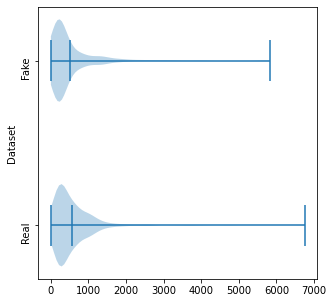

In [ ]:
# visualising distribution of article length using a Violin plot
fig, ax = plt.subplots(figsize=(5,5))
ax.violinplot([fake.words_count, real.words_count][::-1],positions =[1, 2],vert=False,showmeans=True)

labels = ['Fake', 'Real'][::-1]
ax.set_yticks(np.arange(1, len(labels) + 1))
ax.set_yticklabels(labels, rotation='vertical')
ax.set_ylabel('Dataset');

## 2. **Pre-processing**

In [ ]:
fake.sample(5)

,url,title,text,words_count
551,http://hadfnews.ps/post/67078/%D8%A7%D9%84%D8%...,The British do not adhere to homelessness and ...,The British broke the social isolation rules i...,357
175,https://novorosinform.org/808651,Alexander Artamonov: NATO uses COVID-19 to mob...,The COVID-19 pandemic announced by the World H...,1482
82,https://hourpress.net/news-100922.htm,A famous Russian doctor explains the secret of...,Hourly News Date: 04-04-2020 | Since: 4 weeks ...,217
531,https://mobile.twitter.com/hwag_ucmc/status/12...,Twitter,Hybrid Warfare Analytical Group @hwag_ucmc\nIf...,49
582,http://mail.burathanews.com/arabic/reports/365664,Corona's puzzle ... an exciting report that re...,The controversy over the origin of the new cor...,445


In [ ]:
real.sample(5)

,url,title,text,words_count
88,https://yle.fi/uutiset/osasto/news/coronavirus...,Coronavirus shuts down health centre in easter...,Coronavirus shuts down health centre in easter...,297
701,https://www.economist.com/business/2020/03/14/...,The anti - covid industrial complex - Chinese ...,CHINESE DISTILLERS of baijiu are proud of thei...,586
526,https://www.theguardian.com/world/2020/feb/24/...,Coronavirus outbreak a pandemic in all but na...,Coronavirus outbreak a pandemic 'in all but na...,790
287,https://www.bbc.com/news/amp/science-environme...,Climate change : Could the coronavirus crisis ...,Climate change: Could the coronavirus crisis s...,1492
476,https://www.theatlantic.com/ideas/archive/2020...,This Is How We Beat the Coronavirus,While many watched the coronavirus spread acro...,266


In [ ]:
# copy dfs in order to not overwrite
fake_preprocess = fake.copy()
real_preprocess = real.copy()

# create new col with repeated title in 'text' column removed. This is done by replacing the string from the title col with nothing, if it is repeated in the text col
fake_preprocess['text_no_title'] = fake_preprocess.text.replace(fake_preprocess.title[fake_preprocess.title.notnull()], '', regex = True).str.strip()
real_preprocess['text_no_title'] = real_preprocess.text.replace(real_preprocess.title[real_preprocess.title.notnull()], '', regex = True).str.strip()

# update words_count
fake_preprocess['words_count_no_title'] = fake_preprocess['text_no_title'].str.split().str.len()
real_preprocess['words_count_no_title'] = real_preprocess['text_no_title'].str.split().str.len()

fake_preprocess.sample(5)

,url,title,text,words_count,text_no_title,words_count_no_title
538,https://www.alsumaria.tv/news/%D8%AF%D9%88%D9%...,Corona's puzzle ... an exciting report that re...,"This controversy escalated, especially between...",405,"This controversy escalated, especially between...",405
324,http://www.newhub.org/AR/AL/544899,Pirates of the twenty-first century,Pirates of the twenty-first century\nLatest Ne...,27,Latest News Hashtags:\n|\n|\n|\n|\n⁞\nMost Pop...,22
278,https://it.sputniknews.com/italia/202004038934...,Italy responds to Russian defense ministry sta...,In the joint press release of the Farnesina an...,234,In the joint press release of the Farnesina an...,234
190,https://bgr.news-front.info/2020/03/18/udobniy...,"The ""convenient"" deadly coronavirus: The weapo...",The whole world is plunged into coronavirus ch...,823,The whole world is plunged into coronavirus ch...,823
9,https://www.albidda.net/More/3621843.html,Have we got the Corona virus from space ?!,We show you our visitors the most important an...,291,We show you our visitors the most important an...,291


In [ ]:
# drop columns we don't need 
fake_preprocess.drop(columns=['text', 'words_count'], inplace=True)
real_preprocess.drop(columns=['text', 'words_count'], inplace=True)

In [ ]:
# check for empty texts 

[index for index, text_no_title in enumerate(fake_preprocess.text_no_title.values) if str(text_no_title.strip()) == '']

[10, 37, 646]

In [ ]:
# check for empty texts 

[index for index, text_no_title in enumerate(real_preprocess.text_no_title.values) if str(text_no_title.strip()) == '']

[]

In [ ]:
# dropping rows with no text
fake_preprocess.drop([10, 37, 647], axis=0, inplace=True)

Ideally, I would apply text normalization techniques such as dictionary mappings, statistical machine translation (SMT) and spelling-correction based approaches. This would map all incorrect spellings to one word and reduce noise for the model.

In [ ]:
# create binary class for real and fake data before combining to one dataset
real_preprocess['class'] = 0
fake_preprocess['class'] = 1

combined_data = real_preprocess.append(fake_preprocess, ignore_index=True)
del real_preprocess, fake_preprocess

In [ ]:
combined_data.sample(5)

,url,title,text_no_title,words_count_no_title,class
1329,https://sputnik.by/radio/20200323/1044250129/G...,Gasparyan: do not consider yourself smarter th...,"Many have not yet understood, but we have been...",356,1
815,https://orbitt.net/category/us-media/,Orbitt.net,As we approach the middle of March 2020 with S...,5822,1
188,https://www.economist.com/graphic-detail/2020/...,Daily chart - Political bettors pick Joe Biden...,NOTHING IS MORE important to America’s Democra...,423,0
469,https://news.err.ee/1074390/tests-at-tabivere-...,Tests at Tabivere Social Center confirm five c...,({{contentCtrl.commentsTotal}})\nThree residen...,170,0
219,https://www.dw.com/en/wall-streets-worst-week/...,Wall Street ′ s worst week | Business| Economy...,It's been the worst market week on Wall Street...,36,0


In [ ]:
# defining our input variable, reformatting from df to numpy array removing punctuation and stop words
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in combined_data["text_no_title"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

# defining target variable
y = combined_data['class']

## 3. **Model Development**

In [ ]:
import gensim

Word embeddings are vector representations of words, they are used to understand the semantic relationship between words. 

Word2Vec is a pretrained algorithm in word embeddings so it understands the contect of words and can save time when training a model. 

In [ ]:
# setting the dimension
EMBEDDING_DIM = 100
# creating word vectors using Word2Vec
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

# we can check the vector for a chosen word in our dataset, e.g. COVID
w2v_model['covid']

array([-0.43982488, -0.93250793,  0.32351756, -0.33988374,  0.95853907,
        0.78315324, -0.5878785 , -2.2070231 , -2.1743135 , -0.15342131,
       -0.7171488 ,  0.75309867,  0.83777106, -1.7831103 , -0.9042581 ,
       -0.4465237 ,  0.30584022, -1.3651899 , -1.1153502 ,  2.3510113 ,
        0.8014288 , -0.4143526 , -0.44383693,  1.3231564 ,  0.43089992,
       -2.2472796 , -1.0510901 ,  2.0094364 , -0.02629537,  1.1068248 ,
        0.9057163 , -0.26362455, -0.08381478, -0.54366183, -1.2862645 ,
       -0.98103935,  2.6810393 ,  2.346335  , -0.15840687,  0.3379259 ,
       -0.6404225 , -1.8460189 , -0.52478766,  0.3230766 ,  1.4907566 ,
       -0.41490033, -2.307189  ,  1.1429808 ,  0.59722346, -0.3421568 ,
       -0.21610785, -1.1528378 ,  0.87060255, -0.4938505 ,  0.2795104 ,
       -0.37486467, -2.8360155 , -0.05178475, -1.4393603 ,  2.495202  ,
        0.57287884, -1.1719248 , -2.061292  ,  0.5253245 , -0.90661937,
        2.5321991 , -0.75002813,  0.152865  ,  0.46938488, -1.75

In [ ]:
# we need to tokanize the words to numerical representations for the embedding layer of the Neural Network
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# reviewing some word to numerical representations
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

coronavirus -> 1
virus -> 2
people -> 3
said -> 4
19 -> 5
covid -> 6
china -> 7
new -> 8
health -> 9
world -> 10


In [ ]:
# creating the weights for the model
def get_weight_matrix(model, vocab):
    # total vocab size + 0 for unknown words
    vocab_size = len(vocab)+1
    #inetialize weight matrix with all zeros
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix
  
embedding_vectors = get_weight_matrix(w2v_model, word_index)


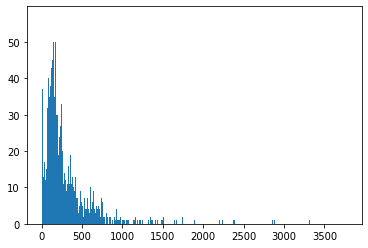

In [ ]:
# defining the max length of an article

plt.hist([len(x) for x in X], bins=500)
plt.show()

# it looks like the vast majority are under 1000 words

In [ ]:
# check that 1000 gives a good distribution

wordcount = np.array([len(x) for x in X])
print('total articles: ', len(X))
print('articles with less than 1000 words: ', len(wordcount[wordcount  < 1000]))

total articles:  1596
articles with less than 1000 words:  1538


In [ ]:
# setting to 1000 with padding

maxlen = 1000
X = pad_sequences(X, maxlen = maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:

# creating layers for neural network model# creatin 
model = Sequential()
#adding a non-trainable embedding layer as input layer
model.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2913900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,031,277
Trainable params: 117,377
Non-trainable params: 2,913,900
_________________________________________________________________


In [ ]:
X_train = X
y_train = y

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)


Epoch 1/6
35/35 [==============================] - 35s 992ms/step - loss: 0.5154 - acc: 0.7610 - val_loss: 0.8945 - val_acc: 0.4342
Epoch 2/6
35/35 [==============================] - 35s 995ms/step - loss: 0.4491 - acc: 0.8084 - val_loss: 0.8046 - val_acc: 0.5971
Epoch 3/6
35/35 [==============================] - 35s 991ms/step - loss: 0.4052 - acc: 0.8371 - val_loss: 0.9369 - val_acc: 0.5073
Epoch 4/6
35/35 [==============================] - 35s 990ms/step - loss: 0.3561 - acc: 0.8639 - val_loss: 2.1355 - val_acc: 0.0230
Epoch 5/6
35/35 [==============================] - 35s 993ms/step - loss: 0.5280 - acc: 0.7619 - val_loss: 1.0256 - val_acc: 0.2276
Epoch 6/6
35/35 [==============================] - 35s 994ms/step - loss: 0.4408 - acc: 0.8057 - val_loss: 0.9176 - val_acc: 0.3841


See Test ipynb file for next step~